<a href="https://colab.research.google.com/github/Bilal3099/Transfer-Learning/blob/main/Xception2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
import math
import os
from glob import glob 
from tqdm import tqdm
from PIL import Image
import cv2 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow import keras
from keras import models
from keras import layers
from sklearn import metrics

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dropout,Dense,GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
input_path = '/content/drive/MyDrive/archive/chest_xray/'
train_ds_path = input_path + 'train'
test_ds_path = input_path + 'test'
val_ds_path = input_path + 'val'

In [ ]:
img_size = 150
batch_size = 32

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   shear_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)


train_batch = train_datagen.flow_from_directory(
              train_ds_path,
              target_size = (img_size, img_size),
              batch_size = batch_size,
              shuffle=True,
              class_mode = 'binary'
)


val_batch = val_datagen.flow_from_directory(
            val_ds_path,
            target_size = (img_size, img_size),
            batch_size = batch_size,
            shuffle=False,
            class_mode = 'binary'
)

test_batch = test_datagen.flow_from_directory(
             test_ds_path,
             target_size = (img_size, img_size),
             batch_size = batch_size,
             shuffle=False,
             class_mode = 'binary'
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
imgs, label = next(train_batch)

In [ ]:
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 10, figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip (images_arr, axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()  


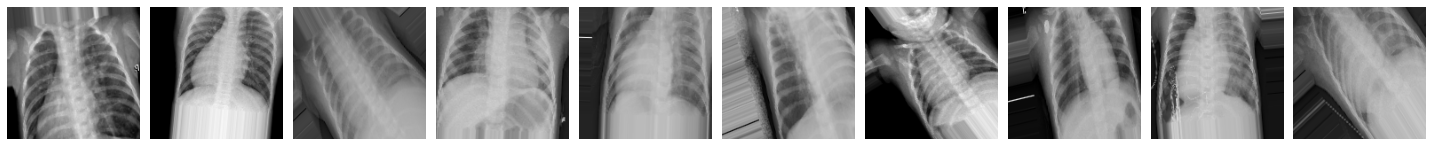

[1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 1. 1.]


In [ ]:
plotImages(imgs)
print(label)

In [ ]:
def build_model(backbone, learning_rate=1e-4):
  model = Sequential()
  model.add(backbone)
  model.add(layers.GlobalAveragePooling2D())
  model.add(layers.Dropout(0.5))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(1, activation='sigmoid'))

  model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=learning_rate),
        metrics=['acc']
    )
  return model

xcep = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(150,150,3)
)

model = build_model(xcep, learning_rate=1e-4)
model.summary()

83683744/83683744 [==============================] - 6s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 batch_normalization_4 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                         

In [ ]:
history = model.fit(
    train_batch,
    steps_per_epoch=163,
    epochs=15,
    validation_data=test_batch,
    validation_steps=20
)

Epoch 1/15
163/163 [==============================] - 1840s 11s/step - loss: 0.3115 - acc: 0.8869 - val_loss: 0.3786 - val_acc: 0.8413
Epoch 2/15
163/163 [==============================] - 104s 637ms/step - loss: 0.1829 - acc: 0.9471 - val_loss: 0.8616 - val_acc: 0.6667
Epoch 3/15
163/163 [==============================] - 103s 629ms/step - loss: 0.1336 - acc: 0.9580 - val_loss: 0.4427 - val_acc: 0.7853
Epoch 4/15
163/163 [==============================] - 103s 631ms/step - loss: 0.1216 - acc: 0.9643 - val_loss: 0.2388 - val_acc: 0.9022
Epoch 5/15
163/163 [==============================] - 103s 633ms/step - loss: 0.0958 - acc: 0.9689 - val_loss: 0.1923 - val_acc: 0.9311
Epoch 6/15
163/163 [==============================] - 105s 640ms/step - loss: 0.0877 - acc: 0.9691 - val_loss: 0.2011 - val_acc: 0.9263
Epoch 7/15
163/163 [==============================] - 107s 657ms/step - loss: 0.0828 - acc: 0.9726 - val_loss: 0.2320 - val_acc: 0.9183
Epoch 8/15
163/163 [=============================

In [ ]:
model.save('XceptionModel.h5')

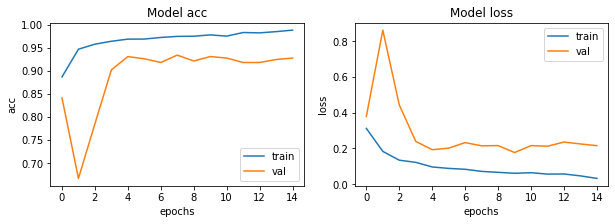

In [ ]:
ig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['acc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
pred = model.predict(val_batch)

1/1 [==============================] - 1s 1s/step


In [ ]:
pred

array([[1.5948226e-01],
       [7.0239663e-02],
       [5.5259043e-01],
       [2.0751870e-01],
       [1.1667451e-01],
       [2.5470820e-01],
       [2.2736393e-09],
       [9.5301633e-10],
       [9.9813581e-01],
       [9.9140853e-01],
       [9.7488075e-01],
       [9.9720532e-01],
       [9.9568498e-01],
       [9.9816847e-01],
       [9.9886858e-01],
       [9.9438924e-01]], dtype=float32)

In [ ]:
y_pred = []
for prob in pred:
    if prob >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [ ]:
y_pred

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]

In [ ]:
y_true = val_batch.classes

In [ ]:
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [ ]:
cm = confusion_matrix(y_true, y_pred)

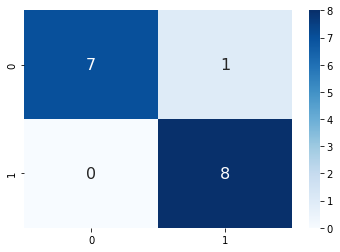

In [ ]:
import seaborn as sn
sn.heatmap(cm, annot=True,cmap="Blues", annot_kws={"size": 16})

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.89      1.00      0.94         8

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.94        16
weighted avg       0.94      0.94      0.94        16



ROC:  0.9375


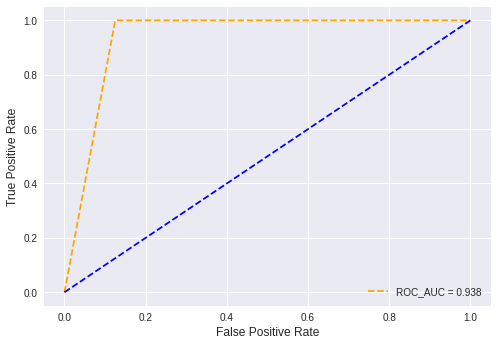

In [ ]:
roc_auc = metrics.roc_auc_score(y_true, y_pred)
print('ROC: ', roc_auc)

random_probs = [0 for i in range(len(y_true))]
p_fpr, t_fpr, thresholds = metrics.roc_curve(y_true, random_probs)
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)

plt.style.use('seaborn')
plt.plot(fpr, tpr, linestyle = '--', color='orange', label='ROC_AUC = %0.3f' % roc_auc)
plt.plot(p_fpr, t_fpr, linestyle = '--', color = 'blue')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc = 'lower right')

plt.show()
